In [2]:
import numpy as np
import matplotlib.pyplot as plt
from abtem import *
from abtem.utils import GaussianDistribution
from ase.io import read
from ase.build import surface, bulk
from tqdm.auto import tqdm

# The quasi-coherent approximation

This notebook explores the difference between the quasicoherent approximation and the correct incoherent summation.

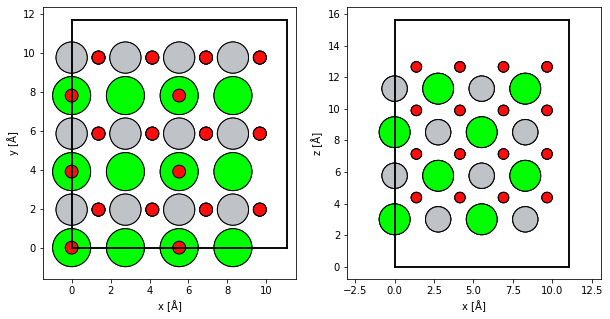

In [3]:
atoms = read('../data/srtio3_110.cif')
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(10,5))
show_atoms(atoms, ax=ax1)
show_atoms(atoms, ax=ax2, plane='xz');

In [4]:
wave = PlaneWave(energy=300e3, sampling=.025)
exit_wave = wave.multislice(atoms, pbar=False)

The quasi-coherent approximation works by applying an envelope  

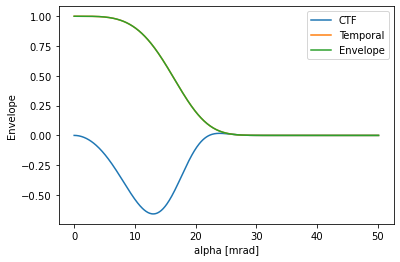

In [5]:
focal_spread = 40
defocus_center = -40

ctf = CTF(energy=300e3, focal_spread=focal_spread, defocus=defocus_center)
ctf.show();

In [6]:
quasicoh_measurement = exit_wave.apply_ctf(ctf=ctf).intensity()

Note that the focal in the contrast transfer function is given as the $1/e$ width, following the convention of the Kirkland's book. Hence, we need to convert this to standard deviation below.

In [7]:
incoh_measurement = exit_wave.allocate_measurement()

for defocus, intensity in GaussianDistribution(defocus_center, focal_spread / np.sqrt(2), 101, 3):
    incoh_measurement += exit_wave.apply_ctf(defocus=defocus).intensity() * intensity

The quasi-coherent approximation becomes worse as focal spread is increased, however, even with a focal spread of 40 Å the results are not terrible.

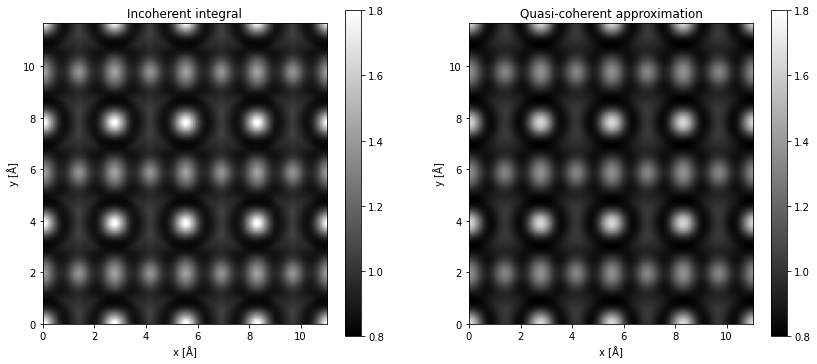

In [8]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(14,6))

incoh_measurement.show(ax=ax1, colorbar=True, vmin=.8, vmax=1.8, title='Incoherent integral')
quasicoh_measurement.show(ax=ax2, colorbar=True, vmin=.8, vmax=1.8, title='Quasi-coherent approximation');

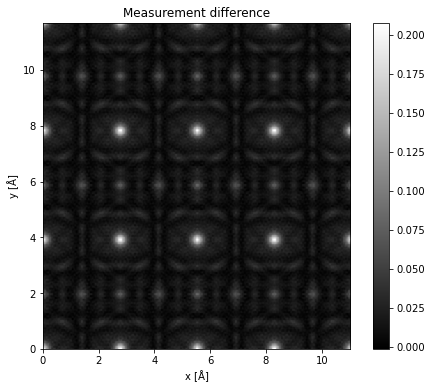

In [10]:
(incoh_measurement-quasicoh_measurement).show(colorbar=True, figsize=(8,6), title='Measurement difference');

# Does it work for CBED?

In [67]:
focal_spread = 40
defocus_center = -40

probe = Probe(semiangle_cutoff=30, energy=80e3, defocus=defocus_center, focal_spread=focal_spread, extent=10, gpts=512)
quasicoh_measurement = probe.build().intensity()

<AxesSubplot:xlabel='alpha [mrad]', ylabel='Envelope'>

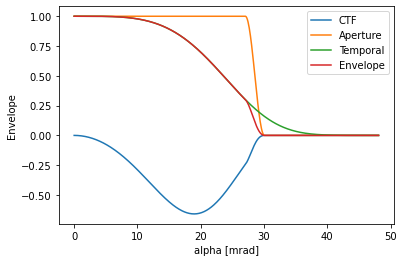

In [68]:
probe.ctf.show()

In [69]:
probe.ctf.focal_spread = 0

incoh_measurement = probe.build().allocate_measurement()

for defocus, intensity in GaussianDistribution(defocus_center, focal_spread / np.sqrt(2), 101, 3):
    probe.ctf.defocus = defocus
    incoh_measurement += probe.build().intensity() * intensity

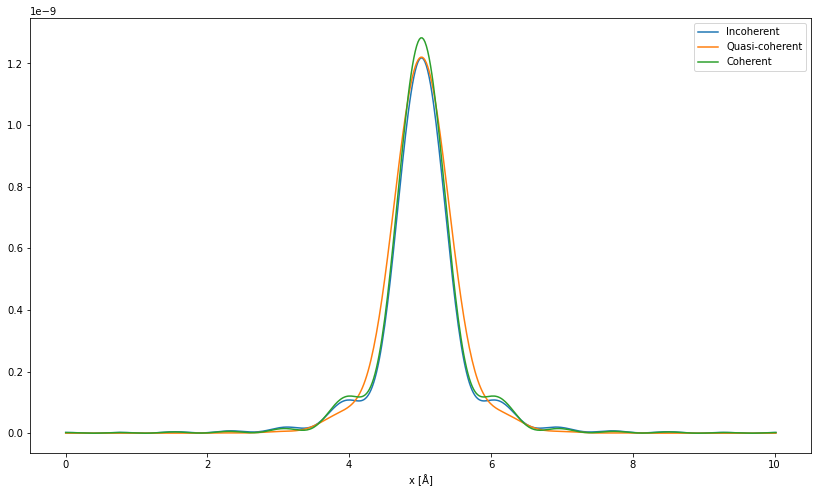

In [72]:
from abtem.measure import probe_profile

probe.ctf.defocus = defocus_center
measurement = probe.build().intensity()

fig,ax=plt.subplots(1,1,figsize=(14,8))

probe_profile(incoh_measurement).show(ax=ax, label='Incoherent')
probe_profile(quasicoh_measurement).show(ax=ax, label='Quasi-coherent')
probe_profile(measurement).show(ax=ax, label='Coherent')

ax.legend()

The quasi-coherent approximation does not seem to work well for CBED and by extension 4DSTEM.